# Start of Code

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import load_img
#from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator


In [33]:
img = keras.preprocessing.image.load_img('./data/train/0cdf5b5d0ce1_03.jpg')


In [34]:
train_data_dir = "./data/train"
train_mask_dir = "./data/train_masks"
train_image_names = os.listdir(train_data_dir)
train_mask_names = os.listdir(train_mask_dir)


In [37]:
def im_gen(train_data_dir, train_mask_dir, train_image_names, train_mask_names, batch_size, img_dim):
    
    '''
    #TODO
    '''
    
    while True:
        ix = np.random.choice(len(train_image_names), batch_size)
        imgs = []
        labels = []
        
        for i in ix:
            img_tmp = keras.preprocessing.image.load_img(train_data_dir + '/' + train_image_names[i], target_size = img_dim + [3])
            img_array = keras.preprocessing.image.img_to_array(img_tmp)/255
            imgs.append(img_array)
            
            
            mask_tmp = keras.preprocessing.image.load_img(train_mask_dir + '/' +  train_mask_names[i], target_size = img_dim + [3])
            mask_array = keras.preprocessing.image.img_to_array(mask_tmp)/255
            labels.append(mask_array[:,:,0])
          
        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels





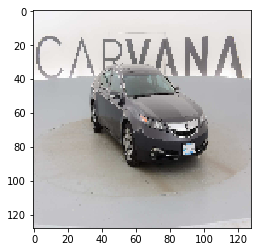

In [38]:
train_gen = im_gen(train_data_dir, train_mask_dir, train_image_names, train_mask_names, 5, [128, 128])
img, mask = next(train_gen)

plt.imshow(img[0])
#plt.imshow(mask[0], alpha=0.5)


plt.show()


In [39]:
def get_unet():
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model